# Causal Inference for Churn Test: Breadth of Engagement AB Test Results Analysis

## Preparation

pip install causalml

### Dependencies

pip install snowflake-snowpark-python
pip install pandas
pip install doubleml
pip install scikit-learn
pip install "snowflake-connector-python[pandas]"

### Import Libraries

In [1]:
#Snowflake Connections
import boto3
import json
from snowflake.snowpark import Session
import yaml

#Basic Libraries
import pandas as pd
import numpy as np
from itertools import product


#DoubleML Model Libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR

#OLS Model
import statsmodels.api as sm
import statsmodels.formula.api as smf

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

#Uplift Modeling
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import auuc_score, qini_score



#plots
import seaborn as sns
import matplotlib.pyplot as plt




from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import auuc_score, qini_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import os



/home/sagemaker-user/ucl_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


## Import Data

### A/B Test Data

In [3]:
# Get Snowflake credentials from AWS Secrets Manager
SECRET_NAME = "arn:aws:secretsmanager:us-east-1:390844750736:secret:/prod/mldp/snowflake/credentials" 

session = boto3.session.Session()
client = session.client(
    service_name='secretsmanager'
)


get_secret_value_response = client.get_secret_value(SecretId=SECRET_NAME)
secret = get_secret_value_response['SecretString']
snf_config = json.loads(secret)

# Create Snowflake connection
session = Session.builder.configs(snf_config).create()

query = f"""
with audience as (
    select *
    from SBX.EMILYY_BREATH_CONTROL_TEST_GROUP_NOV24
),

-- Section reads in the 30 days before the email
pre_email_section_counts as (
    select 
        A.RECIPIENT_CONTACT_ID,
        count(distinct B.SECTION_NAME) as sections_read_prev_1m
    from audience A
    left join SBX.LE_VW_SECTIONS_TEST B 
        on A.RECIPIENT_CONTACT_ID = B.USER_ID
       and B.DAY_DATE >= dateadd('day', -30, '2024-09-27')
       and B.DAY_DATE < '2024-09-27'
    group by 1
),

-- Users with < 2 sections read before the email
pre_email_engaged as (
    select *
    from pre_email_section_counts
    where coalesce(sections_read_prev_1m, 0) < 2
),

-- Active Annual subscribers on the email date
active_entitlement as (
    select A.*,
           B.ENTITLEMENT_KEY,
           B.ENTITLEMENT_PRODUCT_NAME,
           B.ENTITLEMENT_RATEPLAN_TERM,
           B.ENTITLEMENT_RECIPIENT_REGION_CODE,
           B.SUBSCRIBER_TENURE_YEARS
    from audience A
    left join DERIVED.FACT_ENTITLEMENT_DAILY_ACTIVE B
        on A.RECIPIENT_CONTACT_ID = B.RECIPIENT_CONTACT_ID
       and B.ENTITLEMENT_PRODUCT_NAME = 'TE.DIGITAL'
       and B.ENTITLEMENT_RATEPLAN_TERM = 'Annual'
       and B.CALENDAR_DATE = '2024-09-27'
),

-- Final targeting group
targeted_audience as (
    select A.*
    from active_entitlement A
    inner join pre_email_engaged P
        on A.RECIPIENT_CONTACT_ID = P.RECIPIENT_CONTACT_ID
),

-- Ensure entitlement was valid a month before
entitlement_filter as (
    select A.*
    from targeted_audience A
    left join DERIVED.FACT_ENTITLEMENT B
        on A.ENTITLEMENT_KEY = B.ENTITLEMENT_KEY
       and B.ENTITLEMENT_EFFECTIVE_START_DATE <= dateadd('month', -1, '2024-09-27')
),

-- Section reads in 2 weeks after the email
section_counts_fwd_2w as (
    select 
        A.RECIPIENT_CONTACT_ID,
        count(distinct B.SECTION_NAME) as sections_read_fwd_2w,
        listagg(distinct B.SECTION_NAME, ', ') as section_names_fwd_2w,
        case 
            when listagg(distinct B.SECTION_NAME, ', ') ilike '%culture%' 
            then count(distinct B.SECTION_NAME) - 1
            else count(distinct B.SECTION_NAME) 
        end as sections_read_wo_culture_2w
    from audience A
    left join SBX.LE_VW_SECTIONS_TEST B 
        on A.RECIPIENT_CONTACT_ID = B.USER_ID
       and B.DAY_DATE >= '2024-09-27'
       and B.DAY_DATE <= dateadd('week', 2, '2024-09-27')
    group by 1
),

-- Join pre and post read counts
joinback as (
    select 
        A.*,
        s2w.sections_read_fwd_2w,
        s2w.section_names_fwd_2w,
        s2w.sections_read_wo_culture_2w,
        p.sections_read_prev_1m
    from entitlement_filter A
    left join section_counts_fwd_2w s2w 
        on A.RECIPIENT_CONTACT_ID = s2w.RECIPIENT_CONTACT_ID
    left join pre_email_section_counts p
        on A.RECIPIENT_CONTACT_ID = p.RECIPIENT_CONTACT_ID
),

-- Add engagement bands
engagement as (
    select 
        A.*,
        B.engagement_score,
        case 
            when B.ENGAGEMENT_SCORE < 0.1 then 'Very Low'
            when B.ENGAGEMENT_SCORE < 0.5 then 'Low'
            when B.ENGAGEMENT_SCORE < 0.9 then 'Medium'
            else 'High' 
        end as engagement_score_band
    from joinback A
    left join DERIVED.FACT_CUSTOMER_ENGAGEMENT_ROLLING B
        on A.ENTITLEMENT_KEY = B.ENTITLEMENT_KEY
       and B.ROLLING_FLAG = 'ROLLING_30'
       and B.CALENDAR_DATE = '2024-09-27'
)

-- Final metrics: annual_2_reads + pre and post section counts
select 
    ENTITLEMENT_KEY,
    CONTROL_TEST,
    SUBSCRIBER_TENURE_YEARS,
    engagement_score_band,
    sum(sections_read_prev_1m) as total_sections_read_prev_1m,
    sum(sections_read_fwd_2w) as total_sections_read_fwd_2w,
    count(distinct case when sections_read_fwd_2w >= 2 then RECIPIENT_CONTACT_ID end) * 1.0 / count(distinct RECIPIENT_CONTACT_ID) as annual_2_reads
from engagement
group by 
    CONTROL_TEST,
    SUBSCRIBER_TENURE_YEARS,
    engagement_score_band,
    ENTITLEMENT_KEY
"""

try:
    df = session.sql(query).to_pandas()
finally:
    session.close()
df

,ENTITLEMENT_KEY,CONTROL_TEST,SUBSCRIBER_TENURE_YEARS,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.799330e+19,TEST,Y4,Low,1,0,0.0
1,3.880818e+18,CONTROL,Y1,Medium,0,1,0.0
2,9.539141e+18,CONTROL,Y5+,Very Low,0,0,0.0
3,3.901115e+18,TEST,Y5+,Very Low,0,0,0.0
4,6.264435e+18,TEST,Y5+,Very Low,0,0,0.0
...,...,...,...,...,...,...,...
130827,1.308690e+19,CONTROL,Y2,Very Low,0,0,0.0
130828,4.150208e+18,TEST,Y5+,Low,0,0,0.0
130829,1.061301e+19,CONTROL,Y1,Low,0,0,0.0
130830,5.996247e+18,TEST,Y2,Very Low,0,0,0.0


In [4]:
print(df.TOTAL_SECTIONS_READ_PREV_1M.sum())
print(df.TOTAL_SECTIONS_READ_FWD_2W.sum())

20210
45728


### Customer Behaviour Data

In [5]:
query = f"""
  with audience as (
    select *
    from SBX.EMILYY_BREATH_CONTROL_TEST_GROUP_NOV24
),

active_entitlement as (
    select A.*,
           B.ENTITLEMENT_KEY,
           B.ENTITLEMENT_PRODUCT_NAME,
           B.ENTITLEMENT_RATEPLAN_TERM,
           B.ENTITLEMENT_RECIPIENT_REGION_CODE,
           B.SUBSCRIBER_TENURE_YEARS
    from audience A
    left join DERIVED.FACT_ENTITLEMENT_DAILY_ACTIVE B
      on A.RECIPIENT_CONTACT_ID = B.RECIPIENT_CONTACT_ID
     and B.ENTITLEMENT_PRODUCT_NAME = 'TE.DIGITAL'
     and B.ENTITLEMENT_RATEPLAN_TERM in ('Annual')
     and B.CALENDAR_DATE = '2024-09-27'
),

entitlement_filter as (
    select A.ENTITLEMENT_KEY
    from active_entitlement A
    left join DERIVED.FACT_ENTITLEMENT B
      on A.ENTITLEMENT_KEY = B.ENTITLEMENT_KEY
     and B.ENTITLEMENT_EFFECTIVE_START_DATE <= dateadd('month', -1, '2024-09-27')
)

select *
from DERIVED.FACT_CUSTOMER_ENGAGEMENT_ROLLING
where ROLLING_FLAG = 'ROLLING_30'
  and CALENDAR_DATE = '2024-09-27'
  and ENTITLEMENT_KEY in (
      select distinct ENTITLEMENT_KEY
      from entitlement_filter
  );


"""

session = Session.builder.configs(snf_config).create()

try:
    df_entitlement = session.sql(query).to_pandas()
finally:
    session.close()

df_entitlement

,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_KEY,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,...,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_TENURE_YEARS
0,0033z000034DMXnAAO,2024-09-27,3.042116e+18,CEMEA,Spain,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,0033z00003522scAAA,2024-09-27,1.336871e+19,CEMEA,South Africa,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,0033z00002qd7PZAAY,2024-09-27,1.117353e+19,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,0033z00003O7252AAB,2024-09-27,1.643449e+19,CEMEA,Kenya,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,0033z00002st24KAAQ,2024-09-27,2.047709e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131343,0033z00002rvTOVAA2,2024-09-27,1.505375e+19,CEMEA,Italy,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
131344,0033z00003GDT50AAH,2024-09-27,1.371729e+18,CEMEA,Slovakia,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
131345,0033z00002otWm5AAE,2024-09-27,6.930528e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
131346,0033z00003PUjpAAAT,2024-09-27,3.921797e+18,NA,United States,Direct,AR,TE.DIGITAL,Annual,Owned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [6]:
pd.set_option('display.max_columns', None)
df_entitlement

,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_KEY,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,ENTITLEMENT_STUDENT_FLAG,ENTITLEMENT_TRIALIST_FLAG,ENTITLEMENT_FREE_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,TOTAL_SERVED_VOLUME,TOTAL_ENGAGEMENT_COUNT,WEBSITE_VISIT_CNT,WEBSITE_ARTICLE_VIEW_VISIT_CNT,WEBSITE_AUDIO_PLAY_VISIT_CNT,WEBSITE_VIDEO_PLAY_VISIT_CNT,WEBSITE_PAGE_VIEW_CNT,WEBSITE_ARTICLE_VIEW_CNT,WEBSITE_AUDIO_PLAY_CNT,WEBSITE_VIDEO_PLAY_CNT,WEBSITE_VIDEO_PLAY_WEBINAR_CNT,COREAPP_VISIT_CNT,COREAPP_ARTICLE_VIEW_VISIT_CNT,COREAPP_AUDIO_PLAY_VISIT_CNT,COREAPP_VIDEO_PLAY_VISIT_CNT,COREAPP_PAGE_VIEW_CNT,COREAPP_ARTICLE_VIEW_CNT,COREAPP_AUDIO_PLAY_CNT,COREAPP_VIDEO_PLAY_CNT,COREAPP_VIDEO_PLAY_WEBINAR_CNT,LEGACYAPP_VISIT_CNT,LEGACYAPP_ARTICLE_VIEW_VISIT_CNT,LEGACYAPP_AUDIO_PLAY_VISIT_CNT,LEGACYAPP_VIDEO_PLAY_VISIT_CNT,LEGACYAPP_PAGE_VIEW_CNT,LEGACYAPP_ARTICLE_VIEW_CNT,LEGACYAPP_AUDIO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOAPP_VISIT_CNT,ESPRESSOAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOAPP_PAGE_VIEW_CNT,ESPRESSOAPP_ARTICLE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOLEGACYAPP_VISIT_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_PAGE_VIEW_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,NEWSLETTER_CONTENT_OPEN_CNT,NEWSLETTER_CLICKBASED_OPEN_CNT,WEBINAR_ATTEND_CNT,ROLLING_FLAG,SLOT_ID,SUBMISSION_ID,ROW_CREATED_DATETIME,ROW_UPDATED_DATETIME,ROW_CREATED_BY,ROW_UPDATED_BY,ENTITLEMENT_PRODUCT_GRANULAR_NAME,NUMBER_OF_DAYS_ACTIVE,TOTAL_SECTION_READ_CNT,SECTION_LIST,ENGAGEMENT_SCORE,SCORE_WEIGHTED_CONSUMPTION,SCORE_COREAPP_ARTICLE,SCORE_COREAPP_AUDIO,SCORE_COREAPP_VIDEO,SCORE_WEBSITE_ARTICLE,SCORE_WEBSITE_AUDIO,SCORE_WEBSITE_VIDEO,SCORE_NEWSLETTER_CONTENT,SCORE_WEBINAR_ATTEND,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,NEWSLETTER_ESPRESSO_OPEN_CNT,NEWSLETTER_COVERSTORY_OPEN_CNT,NEWSLETTER_MONEYTALKS_OPEN_CNT,NEWSLETTER_CHECKSANDBALANCE_OPEN_CNT,NEWSLETTER_CLIMATEISSUE_OPEN_CNT,NEWSLETTER_SIMPLYSCIENCE_OPEN_CNT,NEWSLETTER_OFFTHECHARTS_OPEN_CNT,NEWSLETTER_BOTTOMLINE_OPEN_CNT,NEWSLETTER_DRUMTOWER_OPEN_CNT,NEWSLETTER_BLIGHTY_OPEN_CNT,NEWSLETTER_ANALYSING_AFRICA_OPEN_CNT,NEWSLETTER_EXTRAORDINARYSTORY_OPEN_CNT,NEWSLETTER_WARROOM_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_SUNDAY_OPEN_CNT,NEWSLETTER_THISWEEK_OPEN_CNT,NEWSLETTER_THISWEEK_SATURDAY_OPEN_CNT,NEWSLETTER_ESSENTIALINDIA_OPEN_CNT,NEWSLETTER_CAFEEUROPA_OPEN_CNT,NEWSLETTER_MIDDLE_EAST_DISPATCH_OPEN_CNT,NEWSLETTER_EL_BOLETIN_OPEN_CNT,NEWSLETTER_THE_US_IN_BRIEF_OPEN_CNT,NEWSLETTER_PLOTTWIST_OPEN_CNT,NEWSLETTER_OTHER_OPEN_CNT,NUMBER_OF_DAYS_ACTIVE_WEB,NUMBER_OF_DAYS_ACTIVE_APP,NUMBER_OF_DAYS_ACTIVE_NEWSLETTER,NUMBER_OF_DAYS_ACTIVE_WEBINAR,PAGE_VIEW_CNT,ARTICLE_VIEW_CNT,AUDIO_PLAY_CNT,VIDEO_PLAY_CNT,WEBSITE_ARTICLE_REGULAR_VIEW_CNT,WEBSITE_ARTICLE_ESPRESSO_VIEW_CNT,WEBSITE_ARTICLE_INTERACTIVE_VIEW_CNT,WEBSITE_AUDIO_PLAY_REGULAR_CNT,WEBSITE_AUDIO_PLAY_PODCAST_CNT,WEBSITE_VIDEO_PLAY_REGULAR_CNT,COREAPP_ARTICLE_REGULAR_VIEW_CNT,COREAPP_ARTICLE_ESPRESSO_VIEW_CNT,COREAPP_ARTICLE_INTERACTIVE_VIEW_CNT,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_TENURE_YEARS
0,0033z000034DMXnAAO,2024-09-27,3.042116e+18,CEMEA,Spain,Direct,AR,TE.DIGITAL,Annual,Owned,Regular,Non-Trialist,Paid,F

In [7]:
df_entitlement.ENTITLEMENT_CONTRACT_TYPE.value_counts()

ENTITLEMENT_CONTRACT_TYPE
AR    131347
FT         1
Name: count, dtype: int64

### Email Engagement Data

In [8]:
query = f"""
select *, 
    case when FIRST_OPEN_DATETIME is not null then 1 else 0 end as open_flag,
    case when FIRST_CLICK_DATETIME is not null then 1 else 0 end as click_flag,
from DERIVED.DIM_COMMUNICATION
where COMM_EMAIL_NAME = 'r.ob.standard.core.all-eng.churn-test.all-term.global..breadth-test..'
and SEND_DATETIME::date = '2024-09-27'
"""

session = Session.builder.configs(snf_config).create()

try:
    df_email = session.sql(query).to_pandas()
finally:
    session.close()
    
df_email.loc[df_email['CLICK_FLAG'] == 1, 'OPEN_FLAG'] = 1
df_email

,DIM_COMM_KEY,SF_CONTACT_ID,SF_CONTACT_KEY,SF_CUSTOMER_STATUS,SF_CONTACT_EMAIL_KEY,COMM_SUBSCRIBER_ID,COMM_SEND_ID,COMM_BATCH_ID,COMM_LIST_ID,LIST_NAME,LIST_TYPE,SEND_DATETIME,TRIGGERED_SEND_EXTERNAL_KEY,SENDER_NAME,COMM_SUBJECT,FIRST_OPEN_DATETIME,FIRST_BOUNCE_DATETIME,FIRST_BOUNCE_CATEGORY,FIRST_BOUNCE_REASON,FIRST_CLICK_DATETIME,FIRST_CLICK_SEND_URL_ID,FIRST_CLICK_URL_ID,FIRST_CLICK_URL,FIRST_CLICK_ALIAS,JOURNEY_ID,JOURNEY_NAME,COMM_EMAIL_TYPE,COMM_CHANNEL_TYPE,COMM_CATEGORY_TYPE,CAMPAIGN_MEDIUM,BUSINESS_AREA,TAXONOMY1,TAXONOMY2,TAXONOMY3,COMMS_TEST_FLAG,COMM_GROUP,TEST_DATE,SOURCE_SYSTEM,ROW_CREATED_DATETIME,ROW_UPDATED_DATETIME,ROW_CREATED_BY,ROW_UPDATED_BY,SLOT_ID,SUBMISSION_ID,COMM_EMAIL_NAME,OPEN_FLAG,CLICK_FLAG
0,1.638068e+19,0033z000035299JAAQ,8.671592e+18,Subscribed,6.943385e+18,238449566,1928033,10,119,None,None,2024-09-27 15:07:37,330666,noreply@e.economist.com,There’s more to us than just economics,NaT,NaT,None,None,NaT,NaN,NaN,None,None,NaN,None,email,online,email,None,None,None,None,None,None,None,NaT,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
1,1.807580e+19,0033z00002rvXr7AAE,1.490159e+19,Subscribed,2.014385e+18,249193228,1928033,206,119,None,None,2024-09-27 15:10:17,330666,noreply@e.economist.com,There’s more to us than just economics,NaT,NaT,None,None,NaT,NaN,NaN,None,None,NaN,None,email,online,email,None,None,None,None,None,None,None,NaT,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
2,1.376703e+19,0033z00002nUFZdAAO,1.274855e+19,Subscribed,1.836910e+19,235072154,1928033,290,119,None,None,2024-09-27 15:11:41,330666,noreply@e.economist.com,There’s more to us than just economics,NaT,NaT,None,None,NaT,NaN,NaN,None,None,NaN,None,email,online,email,None,None,None,None,None,None,None,NaT,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
3,1.596365e+19,0033z00002yI7XHAA0,9.730852e+18,Subscribed,1.325431e+19,273905281,1928033,45,119,None,None,2024-09-27 15:08:09,330666,noreply@e.economist.com,There’s more to us than just economics,2024-09-28 05:57:18,NaT,None,None,NaT,NaN,NaN,None,None,NaN,None,email,online,email,None,None,None,None,None,None,None,NaT,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,1,0
4,1.276924e+19,0033z00003PTRAhAAP,1.455543e+19,Subscribed,3.745582e+18,271996731,1928033,247,119,None,None,2024-09-27 15:10:55,330666,noreply@e.economist.com,There’s more to us than just economics,NaT,NaT,None,None,NaT,NaN,NaN,None,None,NaN,None,email,online,email,None,None,None,None,None,None,None,NaT,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64459,3.214130e+18,0033z00003KHwGUAA1,1.556398e+19,Subscribed,6.273421e+18,265104390,1928033,197,119,None,None,2024-09-27 15:10:08,330666,noreply@e.economist.com,There’s more to us than just economics,NaT,NaT,None,None,NaT,NaN,NaN,None,None,NaN,None,email,online,email,None,None,None,None,None,None,None,NaT,SFMC_NEW,2024-09-29 09:02:11.610000+00:00,2024-09-29 09:02:11.610000+00:00,SERVICEUSER_PROD_AIRFLOW,SERVICEUSER_PROD_AIRFLOW,20240929,1,r.ob.standard.core.all-eng.churn-test.all-term...,0,0
64460,1.241908e+19,0033z00003QOu44AAD,3.999956e+18,Subscribed,2.412765e+18,272886419,1928033,751

## Data Wrangling

### Merging and Filtering

In [9]:

pd.set_option('display.max_rows', 100)  # or None for unlimit
pd.set_option('display.max_columns', None)  # or None for unlimited

#Merging based on ENTITLEMENT_KEY
df_merged = df.merge(df_entitlement, on='ENTITLEMENT_KEY', how='left')


df_merged_complete = df_merged.merge(
    df_email[['SF_CONTACT_ID', 'CLICK_FLAG', 'OPEN_FLAG']],
    on='SF_CONTACT_ID',
    how='left'
)

# Fill missing flags with 0 and ensure integers
df_merged_complete[['CLICK_FLAG', 'OPEN_FLAG']] = df_merged_complete[['CLICK_FLAG', 'OPEN_FLAG']].fillna(0).astype(int)
df_merged_complete

,ENTITLEMENT_KEY,CONTROL_TEST,SUBSCRIBER_TENURE_YEARS_x,ENGAGEMENT_SCORE_BAND,TOTAL_SECTIONS_READ_PREV_1M,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS,SF_CONTACT_ID,CALENDAR_DATE,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RECIPIENT_COUNTRY,ENTITLEMENT_TYPE,ENTITLEMENT_CONTRACT_TYPE,ENTITLEMENT_PRODUCT_NAME,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_GIFT_FLAG,ENTITLEMENT_STUDENT_FLAG,ENTITLEMENT_TRIALIST_FLAG,ENTITLEMENT_FREE_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,TOTAL_SERVED_VOLUME,TOTAL_ENGAGEMENT_COUNT,WEBSITE_VISIT_CNT,WEBSITE_ARTICLE_VIEW_VISIT_CNT,WEBSITE_AUDIO_PLAY_VISIT_CNT,WEBSITE_VIDEO_PLAY_VISIT_CNT,WEBSITE_PAGE_VIEW_CNT,WEBSITE_ARTICLE_VIEW_CNT,WEBSITE_AUDIO_PLAY_CNT,WEBSITE_VIDEO_PLAY_CNT,WEBSITE_VIDEO_PLAY_WEBINAR_CNT,COREAPP_VISIT_CNT,COREAPP_ARTICLE_VIEW_VISIT_CNT,COREAPP_AUDIO_PLAY_VISIT_CNT,COREAPP_VIDEO_PLAY_VISIT_CNT,COREAPP_PAGE_VIEW_CNT,COREAPP_ARTICLE_VIEW_CNT,COREAPP_AUDIO_PLAY_CNT,COREAPP_VIDEO_PLAY_CNT,COREAPP_VIDEO_PLAY_WEBINAR_CNT,LEGACYAPP_VISIT_CNT,LEGACYAPP_ARTICLE_VIEW_VISIT_CNT,LEGACYAPP_AUDIO_PLAY_VISIT_CNT,LEGACYAPP_VIDEO_PLAY_VISIT_CNT,LEGACYAPP_PAGE_VIEW_CNT,LEGACYAPP_ARTICLE_VIEW_CNT,LEGACYAPP_AUDIO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_CNT,LEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOAPP_VISIT_CNT,ESPRESSOAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOAPP_PAGE_VIEW_CNT,ESPRESSOAPP_ARTICLE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_CNT,ESPRESSOAPP_VIDEO_PLAY_WEBINAR_CNT,ESPRESSOLEGACYAPP_VISIT_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_VISIT_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_VISIT_CNT,ESPRESSOLEGACYAPP_PAGE_VIEW_CNT,ESPRESSOLEGACYAPP_ARTICLE_VIEW_CNT,ESPRESSOLEGACYAPP_AUDIO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_CNT,ESPRESSOLEGACYAPP_VIDEO_PLAY_WEBINAR_CNT,NEWSLETTER_CONTENT_OPEN_CNT,NEWSLETTER_CLICKBASED_OPEN_CNT,WEBINAR_ATTEND_CNT,ROLLING_FLAG,SLOT_ID,SUBMISSION_ID,ROW_CREATED_DATETIME,ROW_UPDATED_DATETIME,ROW_CREATED_BY,ROW_UPDATED_BY,ENTITLEMENT_PRODUCT_GRANULAR_NAME,NUMBER_OF_DAYS_ACTIVE,TOTAL_SECTION_READ_CNT,SECTION_LIST,ENGAGEMENT_SCORE,SCORE_WEIGHTED_CONSUMPTION,SCORE_COREAPP_ARTICLE,SCORE_COREAPP_AUDIO,SCORE_COREAPP_VIDEO,SCORE_WEBSITE_ARTICLE,SCORE_WEBSITE_AUDIO,SCORE_WEBSITE_VIDEO,SCORE_NEWSLETTER_CONTENT,SCORE_WEBINAR_ATTEND,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,NEWSLETTER_ESPRESSO_OPEN_CNT,NEWSLETTER_COVERSTORY_OPEN_CNT,NEWSLETTER_MONEYTALKS_OPEN_CNT,NEWSLETTER_CHECKSANDBALANCE_OPEN_CNT,NEWSLETTER_CLIMATEISSUE_OPEN_CNT,NEWSLETTER_SIMPLYSCIENCE_OPEN_CNT,NEWSLETTER_OFFTHECHARTS_OPEN_CNT,NEWSLETTER_BOTTOMLINE_OPEN_CNT,NEWSLETTER_DRUMTOWER_OPEN_CNT,NEWSLETTER_BLIGHTY_OPEN_CNT,NEWSLETTER_ANALYSING_AFRICA_OPEN_CNT,NEWSLETTER_EXTRAORDINARYSTORY_OPEN_CNT,NEWSLETTER_WARROOM_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_OPEN_CNT,NEWSLETTER_ECONOMISTTODAY_SUNDAY_OPEN_CNT,NEWSLETTER_THISWEEK_OPEN_CNT,NEWSLETTER_THISWEEK_SATURDAY_OPEN_CNT,NEWSLETTER_ESSENTIALINDIA_OPEN_CNT,NEWSLETTER_CAFEEUROPA_OPEN_CNT,NEWSLETTER_MIDDLE_EAST_DISPATCH_OPEN_CNT,NEWSLETTER_EL_BOLETIN_OPEN_CNT,NEWSLETTER_THE_US_IN_BRIEF_OPEN_CNT,NEWSLETTER_PLOTTWIST_OPEN_CNT,NEWSLETTER_OTHER_OPEN_CNT,NUMBER_OF_DAYS_ACTIVE_WEB,NUMBER_OF_DAYS_ACTIVE_APP,NUMBER_OF_DAYS_ACTIVE_NEWSLETTER,NUMBER_OF_DAYS_ACTIVE_WEBINAR,PAGE_VIEW_CNT,ARTICLE_VIEW_CNT,AUDIO_PLAY_CNT,VIDEO_PLAY_CNT,WEBSITE_ARTICLE_REGULAR_VIEW_CNT,WEBSITE_ARTICLE_ESPRESSO_VIEW_CNT,WEBSITE_ARTICLE_INTERACTIVE_VIEW_CNT,WEBSITE_AUDIO_PLAY_REGULAR_CNT,WEBSITE_AUDIO_PLAY_PODCAST_CNT,WEBSITE_VIDEO_PLAY_REGULAR_CNT,COREAPP_ARTICLE_REGULAR_VIEW_CNT,COREAPP_ARTICLE_ESPRESSO_VIEW_CNT,COREAPP_ARTICLE_INTERACTIVE_VIEW_CNT,COREAPP_AUDIO_PLAY_REGULAR_CNT,COREAPP_AUDIO_PLAY_PODCAST_CNT,COREAPP_VIDEO_PLAY_REGULAR_CNT,ESPRESSOAPP_ARTICLE_REGULAR_VIEW_CNT,ESPRESSOAPP_ARTICLE_ESPRESSO_VIEW_CNT,ESPRESSOAPP_ARTICLE_INTERACTIVE_VIEW_CNT,ESPRESSOAPP_AUDIO_PLAY_REGULAR_CNT,ESPRESSOAPP_AUDIO_PLAY_PODCAST_CNT,ESPRESSOAPP_VIDEO_PLAY_REGULAR_CNT,SUBSCRIBER_

In [10]:
df_merged_complete.columns.to_list()

['ENTITLEMENT_KEY',
 'CONTROL_TEST',
 'SUBSCRIBER_TENURE_YEARS_x',
 'ENGAGEMENT_SCORE_BAND',
 'TOTAL_SECTIONS_READ_PREV_1M',
 'TOTAL_SECTIONS_READ_FWD_2W',
 'ANNUAL_2_READS',
 'SF_CONTACT_ID',
 'CALENDAR_DATE',
 'ENTITLEMENT_RECIPIENT_REGION_CODE',
 'ENTITLEMENT_RECIPIENT_COUNTRY',
 'ENTITLEMENT_TYPE',
 'ENTITLEMENT_CONTRACT_TYPE',
 'ENTITLEMENT_PRODUCT_NAME',
 'ENTITLEMENT_RATEPLAN_TERM',
 'ENTITLEMENT_GIFT_FLAG',
 'ENTITLEMENT_STUDENT_FLAG',
 'ENTITLEMENT_TRIALIST_FLAG',
 'ENTITLEMENT_FREE_FLAG',
 'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
 'ENTITLEMENT_RENEWAL_CATEGORY',
 'SUBSCRIBER_TENURE_DAYS',
 'TOTAL_SERVED_VOLUME',
 'TOTAL_ENGAGEMENT_COUNT',
 'WEBSITE_VISIT_CNT',
 'WEBSITE_ARTICLE_VIEW_VISIT_CNT',
 'WEBSITE_AUDIO_PLAY_VISIT_CNT',
 'WEBSITE_VIDEO_PLAY_VISIT_CNT',
 'WEBSITE_PAGE_VIEW_CNT',
 'WEBSITE_ARTICLE_VIEW_CNT',
 'WEBSITE_AUDIO_PLAY_CNT',
 'WEBSITE_VIDEO_PLAY_CNT',
 'WEBSITE_VIDEO_PLAY_WEBINAR_CNT',
 'COREAPP_VISIT_CNT',
 'COREAPP_ARTICLE_VIEW_VISIT_CNT',
 'COREAPP_AUDIO_PLA

In [11]:
#Only Use Necessary Columns
df_filtered = df_merged_complete[[
    'ENTITLEMENT_KEY', 
    'CONTROL_TEST', 
    'ENTITLEMENT_RECIPIENT_REGION_CODE', 
    'ENTITLEMENT_RATEPLAN_TERM', 
    'ENTITLEMENT_STUDENT_FLAG', 
    'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
    'ENTITLEMENT_RENEWAL_CATEGORY',
    'SUBSCRIBER_TENURE_DAYS', 
    'SCORE_BREADTH',
    'SCORE_FREQUENCY',
    'WEIGHTED_CONSUMPTION',
    'TOTAL_SECTIONS_READ_PREV_1M',
    'OPEN_FLAG',
    'CLICK_FLAG',
    'TOTAL_SECTIONS_READ_FWD_2W',
    'ANNUAL_2_READS']]
df_filtered     

,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.799330e+19,TEST,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0,0.0
1,3.880818e+18,CONTROL,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,1,0.0
2,9.539141e+18,CONTROL,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0,0.0
3,3.901115e+18,TEST,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0,0.0
4,6.264435e+18,TEST,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130827,1.308690e+19,CONTROL,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0,0.0
130828,4.150208e+18,TEST,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0,0.0
130829,1.061301e+19,CONTROL,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0,0.0
130830,5.996247e+18,TEST,NA,Annual,Regular,False,AR Annual CP2,512.0,0.002,0.002,0.0,0,0,0,0,0.0


### Data Imputation

In [12]:
# Change Treatment to Binary
df_filtered['CONTROL_TEST'] = df_filtered['CONTROL_TEST'].map({'CONTROL':0, 'TEST':1})
#df_filtered.rename(columns={'SUBSCRIBER_TENURE_YEARS_x': 'SUBSCRIBER_TENURE_YEARS'}, inplace=True)


#Count Nan Rows
nan_rows = df_filtered[df_filtered.isnull().any(axis=1)]
num_nan_rows = len(nan_rows)
print(num_nan_rows)

#Delete Nan Rows
df_filtered = df_filtered.dropna()
df_filtered = df_filtered.reset_index(drop=True)


#Delete rows where SUBSCRIBER_TENURE_YEARS is Uknown
#df_filtered = df_filtered[df_filtered['SUBSCRIBER_TENURE_YEARS'] != 'Unknown']
df_filtered

673


/tmp/ipykernel_6580/648054361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CONTROL_TEST'] = df_filtered['CONTROL_TEST'].map({'CONTROL':0, 'TEST':1})


,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,TOTAL_SECTIONS_READ_FWD_2W,ANNUAL_2_READS
0,1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0,0.0
1,3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,1,0.0
2,9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0,0.0
3,3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0,0.0
4,6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130154,1.308690e+19,0,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0,0.0
130155,4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0,0.0
130156,1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0,0.0
130157,5.996247e+18,1,NA,Annual,Regular,False,AR Annual CP2,512.0,0.002,0.002,0.0,0,0,0,0,0.0


## Uplift Modeling

### Version 1 Uplift Modeling: Initial Model

In [13]:
df_uplift = df_filtered.copy()

cat_cols = [
    'ENTITLEMENT_RECIPIENT_REGION_CODE',
    'ENTITLEMENT_RATEPLAN_TERM',
    'ENTITLEMENT_STUDENT_FLAG',
    'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
    'ENTITLEMENT_RENEWAL_CATEGORY',
]

df_uplift[cat_cols] = df_uplift[cat_cols].astype('category')

df_uplift = df_uplift.drop(columns=['TOTAL_SECTIONS_READ_FWD_2W'])

print(df_uplift.dtypes)
df_uplift


ENTITLEMENT_KEY                           float64
CONTROL_TEST                                int64
ENTITLEMENT_RECIPIENT_REGION_CODE        category
ENTITLEMENT_RATEPLAN_TERM                category
ENTITLEMENT_STUDENT_FLAG                 category
IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG    category
ENTITLEMENT_RENEWAL_CATEGORY             category
SUBSCRIBER_TENURE_DAYS                    float64
SCORE_BREADTH                             float64
SCORE_FREQUENCY                           float64
WEIGHTED_CONSUMPTION                      float64
TOTAL_SECTIONS_READ_PREV_1M                 int64
OPEN_FLAG                                   int64
CLICK_FLAG                                  int64
ANNUAL_2_READS                            float64
dtype: object


,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,ANNUAL_2_READS
0,1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0.0
1,3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,0.0
2,9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0.0
3,3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0.0
4,6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130154,1.308690e+19,0,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0.0
130155,4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0.0
130156,1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0.0
130157,5.996247e+18,1,NA,Annual,Regular,False,AR Annual CP2,512.0,0.002,0.002,0.0,0,0,0,0.0


In [14]:
# Setup features with dummy encoding
X = pd.get_dummies(df_uplift.drop(columns=['ENTITLEMENT_KEY', 'CONTROL_TEST', 'ANNUAL_2_READS']), drop_first=True)

# Binary target
y = df_uplift['ANNUAL_2_READS']

# Treatment as string for causalml
treatment = df_uplift['CONTROL_TEST'].astype(str)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.3, random_state=42
)

# Train uplift model
from causalml.inference.tree import UpliftRandomForestClassifier
uplift_rf = UpliftRandomForestClassifier(control_name='0')
uplift_rf.fit(X_train.values, treatment=treatment_train.values, y=y_train.values)

# Predict uplift scores
y_pred = uplift_rf.predict(X_test.values)

uplift_tree = uplift_rf.uplift_forest[0]

pd.Series(uplift_tree.feature_importances_, index = X_train.columns).sort_values().plot(kind='barh', figsize=(12,8))

import numpy as np

uplift_results = pd.DataFrame(y_pred, columns=uplift_rf.classes_[1:])

best_treatment = np.where(uplift_results['1'] < 0, '0', '1')  # Assuming '1' is treatment, '0' is control

auuc_metrics = (
    uplift_results.assign(
        is_treated=(treatment_test.values != '0').astype(int),
        conversion=y_test.values,
        uplift=uplift_results.max(axis=1)
    )
    .drop(columns=list(uplift_rf.classes_[1:]))
)

from causalml.metrics import plot_gain

# Plot the uplift (gain) curve
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')


from causalml.metrics import auuc_score
score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

import numpy as np

# Make a copy of your metrics
auuc_random = auuc_metrics.copy()

# Shuffle the uplift column to simulate random targeting
np.random.seed(42)
auuc_random['uplift'] = np.random.permutation(auuc_random['uplift'].values)

from causalml.metrics import qini_score

qini = qini_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(f"Qini Score: {qini}")

# Compute AUUC for random targeting
random_auuc = auuc_score(auuc_random, outcome_col='conversion', treatment_col='is_treated')
print(f"Random AUUC (baseline): {random_auuc}")

normalized_auuc = (score - random_auuc) / abs(random_auuc)
print(f"Normalized AUUC: {normalized_auuc}")





In [14]:
len(y_pred)

39048

### Version 2 Uplift Modeling: Handling Data Imbalance

In [1]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# --- Step 0: Set ENTITLEMENT_KEY as index ---
#df_uplift = df_uplift.set_index('ENTITLEMENT_KEY')

# --- Step 1: Define key columns ---
target_col = 'ANNUAL_2_READS'
treatment_col = 'CONTROL_TEST'

# Separate variables
X = df_uplift.drop(columns=[treatment_col, target_col]).copy()
y = df_uplift[target_col]
treatment = df_uplift[treatment_col].astype(str)

# Preserve original index for recovery after resampling
X['original_index'] = X.index

# --- Step 2: Oversample minority class ---
ros = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_over, y_over = ros.fit_resample(X, y)

# Restore original index
X_over.index = X_over['original_index']
X_over = X_over.drop(columns='original_index')

# --- Step 3: Undersample majority class to match ---
X_over['original_index'] = X_over.index
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_bal, y_bal = rus.fit_resample(X_over, y_over)

# Restore original index again
X_bal.index = X_bal['original_index']
X_bal = X_bal.drop(columns='original_index')

# --- Step 4: Align treatment with balanced index ---
treatment_bal = treatment.loc[X_bal.index].reset_index(drop=True)

# --- Step 5: Dummy encode categorical features ---
cat_cols = [
    'ENTITLEMENT_RECIPIENT_REGION_CODE',
    'ENTITLEMENT_RATEPLAN_TERM',
    'ENTITLEMENT_STUDENT_FLAG',
    'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
    'ENTITLEMENT_RENEWAL_CATEGORY',
]

X_bal[cat_cols] = X_bal[cat_cols].astype('category')
X_encoded = pd.get_dummies(X_bal, drop_first=True)



# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X_encoded, y_bal, treatment_bal, test_size=0.3
)

# Train uplift model
from causalml.inference.tree import UpliftRandomForestClassifier
uplift_rf = UpliftRandomForestClassifier(control_name='0', random_state=45)
uplift_rf.fit(X_train.values, treatment=treatment_train.values, y=y_train.values)

# Predict uplift scores
y_pred = uplift_rf.predict(X_test.values)
uplift_tree = uplift_rf.uplift_forest[0]

pd.Series(uplift_tree.feature_importances_, index = X_train.columns).sort_values().plot(kind='barh', figsize=(12,8))


NameError: name 'df_uplift' is not defined

In [25]:
import pickle

# Save model to pickle file
with open('uplift_rf_model.pkl', 'wb') as f:
    pickle.dump(uplift_rf, f)


: 

uplift    1.000433
dtype: float64
Qini Score: uplift    0.532329
dtype: float64
Random AUUC (baseline): uplift    0.519856
dtype: float64
Normalized AUUC: uplift    0.924442
dtype: float64


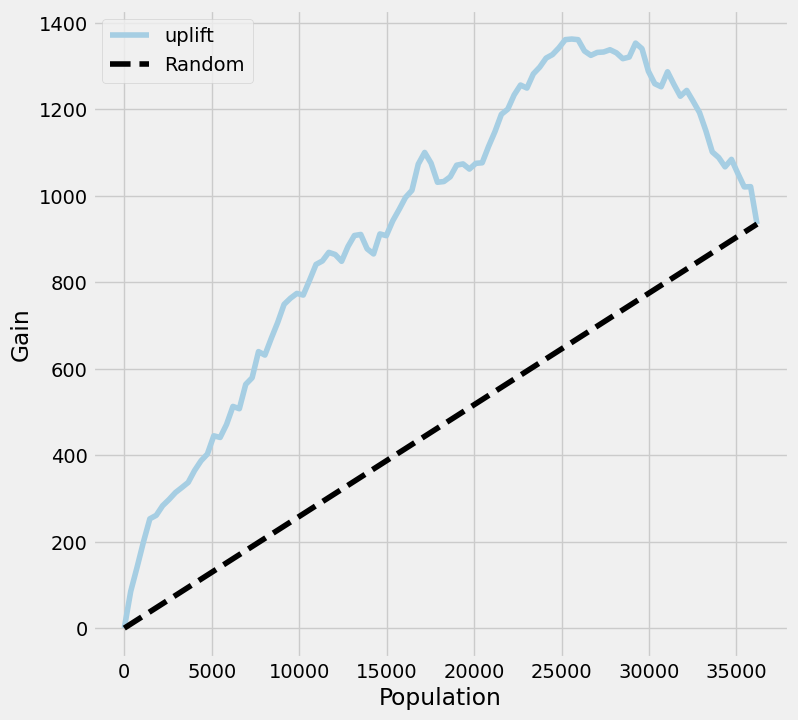

In [18]:
import numpy as np

uplift_results = pd.DataFrame(y_pred, columns=uplift_rf.classes_[1:])

best_treatment = np.where(uplift_results['1'] < 0, '0', '1')  # Assuming '1' is treatment, '0' is control

auuc_metrics = (
    uplift_results.assign(
        is_treated=(treatment_test.values != '0').astype(int),
        conversion=y_test.values,
        uplift=uplift_results.max(axis=1)
    )
    .drop(columns=list(uplift_rf.classes_[1:]))
)

from causalml.metrics import plot_gain

# Plot the uplift (gain) curve
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')


from causalml.metrics import auuc_score
score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

import numpy as np

# Make a copy of your metrics
auuc_random = auuc_metrics.copy()

# Shuffle the uplift column to simulate random targeting
np.random.seed(42)
auuc_random['uplift'] = np.random.permutation(auuc_random['uplift'].values)

from causalml.metrics import qini_score

qini = qini_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(f"Qini Score: {qini}")

# Compute AUUC for random targeting
random_auuc = auuc_score(auuc_random, outcome_col='conversion', treatment_col='is_treated')
print(f"Random AUUC (baseline): {random_auuc}")

normalized_auuc = (score - random_auuc) / abs(random_auuc)
print(f"Normalized AUUC: {normalized_auuc}")




In [19]:
auuc_metrics

,is_treated,conversion,uplift
0,1,1.0,0.047955
1,1,1.0,0.039573
2,1,0.0,0.041159
3,1,0.0,-0.035725
4,0,0.0,0.051544
...,...,...,...
36174,1,1.0,0.031298
36175,0,0.0,0.029144
36176,1,1.0,0.034329
36177,1,1.0,0.051544


In [20]:
uplift_results

,1
0,0.047955
1,0.039573
2,0.041159
3,-0.035725
4,0.051544
...,...
36174,0.031298
36175,0.029144
36176,0.034329
36177,0.051544


In [25]:
df_uplift

,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,ANNUAL_2_READS
ENTITLEMENT_KEY,,,,,,,,,,,,,,
1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0.0
3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,0.0
9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0.0
3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0.0
6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.308690e+19,0,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0.0
4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0.0
1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0.0


In [26]:
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_rf.uplift_forest[0]

# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, X_train.columns)

WEIGHTED_CONSUMPTIONtreatment_group_key >= 239.97400000000053?
yes -> SUBSCRIBER_TENURE_DAYStreatment_group_key >= 1545.0?
		yes -> SUBSCRIBER_TENURE_DAYStreatment_group_key >= 3144.5?
				yes -> [np.float64(0.8041237113402062), np.float64(0.6729559748427673)]
				no  -> ENTITLEMENT_RECIPIENT_REGION_CODE_NAtreatment_group_key >= 0.1?
						yes -> [np.float64(0.42857142857142855), np.float64(0.6859504132231405)]
						no  -> [np.float64(0.5660377358490566), np.float64(0.7592592592592593)]
		no  -> SUBSCRIBER_TENURE_DAYStreatment_group_key >= 84.0?
				yes -> SCORE_FREQUENCYtreatment_group_key >= 0.959?
						yes -> [np.float64(0.6908690869086909), np.float64(0.525965379494008)]
						no  -> [np.float64(0.48936170212765956), np.float64(0.6081081081081081)]
				no  -> [np.float64(0.609375), np.float64(0.6821705426356589)]
no  -> ENTITLEMENT_RECIPIENT_REGION_CODE_CEMEAtreatment_group_key >= 0.1?
		yes -> SCORE_BREADTHtreatment_group_key >= 0.027?
				yes -> SUBSCRIBER_TENURE_DAYStreatment_

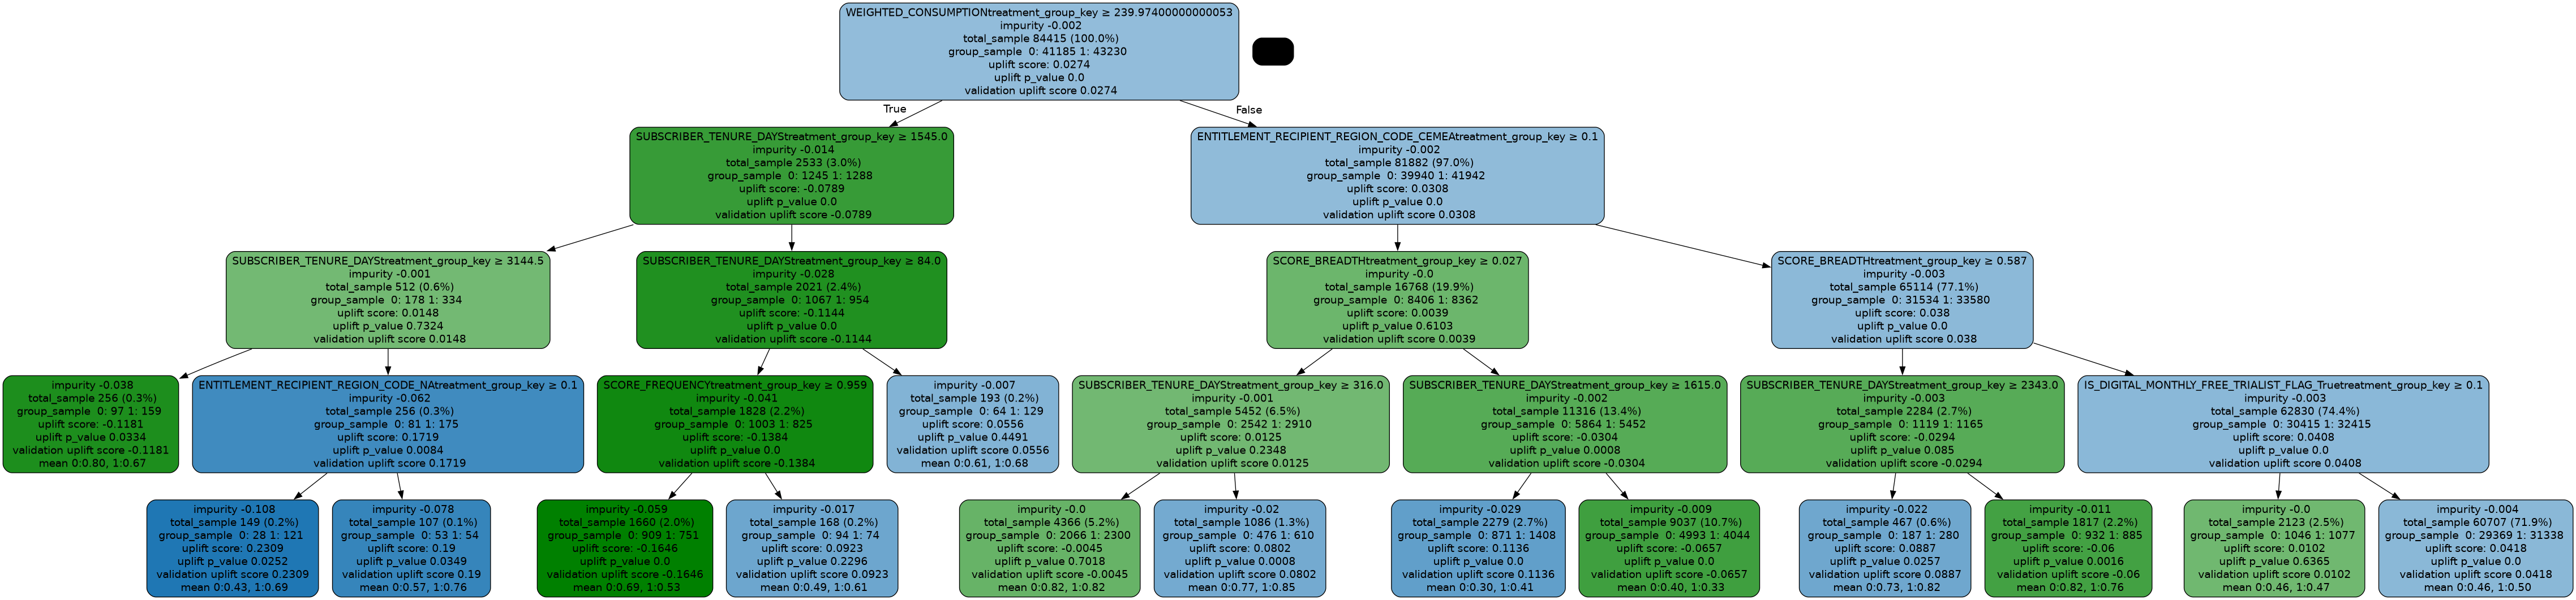

In [27]:
from IPython.display import Image
# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, X_train.columns)
Image(graph.create_png())

### Prediction

In [28]:
import pandas as pd

# 1. Create DataFrame from model predictions
uplift_results = pd.DataFrame(uplift_rf.predict(X_test.values), columns=['uplift'])

# 2. Add user_id from index (since index is unique even if user IDs aren't)
uplift_results['user_id'] = X_test.index

# 3. Sort by uplift descending
uplift_results_sorted = uplift_results.sort_values(by='uplift', ascending=False).reset_index(drop=True)

# 4. Show Top 10 Customers to Target
print("Customer List Sorted by Predicted Uplift:")
display(uplift_results_sorted[['user_id', 'uplift']].head(10))


Customer List Sorted by Predicted Uplift:


,user_id,uplift
0,1.235189e+19,0.152664
1,1.321419e+19,0.152664
2,1.489871e+18,0.149533
3,5.056286e+18,0.149533
4,1.065644e+19,0.149533
5,4.855981e+18,0.149533
6,1.489871e+18,0.149533
7,1.831166e+19,0.143052
8,1.120740e+19,0.140970
9,1.277781e+19,0.140970


In [29]:
import pandas as pd

# 1. Create DataFrame from uplift predictions
uplift_results = pd.DataFrame(uplift_rf.predict(X_test.values), columns=['uplift'])
uplift_results['user_id'] = X_test.index

# 2. Sort by uplift descending
uplift_results_sorted = uplift_results.sort_values(by='uplift', ascending=False).reset_index(drop=True)

# 3. Calculate Rank and Decile
uplift_results_sorted['rank'] = uplift_results_sorted['uplift'].rank(method='first', ascending=False)
uplift_results_sorted['decile'] = pd.qcut(uplift_results_sorted['rank'], 10, labels=False)

# 4. Define Decile Labels
decile_labels = [
    "top 10%", "top 10%-20%", "top 20%-30%", "top 30%-40%", "top 40%-50%", 
    "top 50%-60%", "top 60%-70%", "top 70%-80%", "top 80%-90%", "bottom 10%"
]
uplift_results_sorted['decile_label'] = uplift_results_sorted['decile'].map(lambda x: decile_labels[int(x)])

# 5. Final Column Order for Output
column_order = ['user_id', 'uplift', 'rank', 'decile', 'decile_label']

# 6. Display Top 10
print("Top 10 customers by predicted uplift with deciles:")
display(uplift_results_sorted[column_order].head(10))

# 7. Export to CSV
uplift_results_sorted[column_order].to_csv('customer_list_sorted_by_uplift.csv', index=False)
print("Customer list has been saved to 'customer_list_sorted_by_uplift.csv'")


Top 10 customers by predicted uplift with deciles:


,user_id,uplift,rank,decile,decile_label
0,1.235189e+19,0.152664,1.0,0,top 10%
1,1.321419e+19,0.152664,2.0,0,top 10%
2,1.489871e+18,0.149533,3.0,0,top 10%
3,5.056286e+18,0.149533,4.0,0,top 10%
4,1.065644e+19,0.149533,5.0,0,top 10%
5,4.855981e+18,0.149533,6.0,0,top 10%
6,1.489871e+18,0.149533,7.0,0,top 10%
7,1.831166e+19,0.143052,8.0,0,top 10%
8,1.120740e+19,0.140970,9.0,0,top 10%
9,1.277781e+19,0.140970,10.0,0,top 10%


Customer list has been saved to 'customer_list_sorted_by_uplift.csv'


In [30]:
df_uplift.ANNUAL_2_READS.value_counts()

ANNUAL_2_READS
0.0    120595
1.0      9564
Name: count, dtype: int64

In [31]:
from causalml.metrics import auuc_score
score = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
print(score)

uplift    0.846943
dtype: float64


In [32]:
X_encoded

,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,ENTITLEMENT_RECIPIENT_REGION_CODE_CEMEA,ENTITLEMENT_RECIPIENT_REGION_CODE_LA,ENTITLEMENT_RECIPIENT_REGION_CODE_NA,ENTITLEMENT_RECIPIENT_REGION_CODE_UK,ENTITLEMENT_STUDENT_FLAG_Student,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG_True,ENTITLEMENT_RENEWAL_CATEGORY_AR Annual CP2,ENTITLEMENT_RENEWAL_CATEGORY_AR Annual CP3+,ENTITLEMENT_RENEWAL_CATEGORY_Agent CP2,ENTITLEMENT_RENEWAL_CATEGORY_Other
original_index,,,,,,,,,,,,,,,,,
1.106473e+19,994.0,0.027,0.990,93.5,1,0,0,True,False,False,False,False,False,False,True,False,False
1.567347e+19,295.0,0.002,0.702,81.4,0,1,0,False,False,False,False,True,False,False,False,False,False
7.351967e+18,1240.0,0.002,0.982,118.4,0,0,0,True,False,False,False,False,False,False,True,False,False
7.763239e+18,282.0,0.002,0.946,81.4,0,0,0,False,False,False,False,False,False,False,False,False,False
1.214576e+19,652.0,0.002,0.002,0.0,0,0,0,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.693278e+18,269.0,0.002,0.005,1.0,0,0,0,False,False,True,False,False,False,False,False,False,False
1.539891e+19,988.0,0.027,0.018,3.3,1,0,0,False,False,True,False,False,False,False,True,False,False
1.246545e+19,1286.0,0.002,0.002,0.0,0,0,0,False,False,False,False,False,False,False,True,False,False


In [33]:
# 1. Predict uplift scores
uplift_matrix = uplift_rf.predict(X_encoded.values)

# 2. Safely extract uplift scores
# If it's a 2D array with 2+ columns, pick the treatment group column (usually '1')
# If it's 1D or single-column, use it directly
if uplift_matrix.ndim == 2 and uplift_matrix.shape[1] > 1:
    uplift_scores = uplift_matrix[:, 1]  # index 1 for treatment group
else:
    uplift_scores = uplift_matrix.flatten()

# 3. Build the output DataFrame
uplift_df = pd.DataFrame({
    'user_id': X_encoded.index,
    'uplift': uplift_scores
}).dropna()

# 4. Sort and rank
uplift_df_sorted = uplift_df.sort_values(by='uplift', ascending=False).reset_index(drop=True)
uplift_df_sorted['rank'] = uplift_df_sorted['uplift'].rank(method='first', ascending=False)
uplift_df_sorted['decile'] = pd.qcut(uplift_df_sorted['rank'], 10, labels=False)

# Optional: human-friendly decile labels
decile_labels = [
    "top 10%", "top 10–20%", "top 20–30%", "top 30–40%", "top 40–50%",
    "top 50–60%", "top 60–70%", "top 70–80%", "top 80–90%", "bottom 10%"
]
uplift_df_sorted['decile_label'] = uplift_df_sorted['decile'].map(lambda x: decile_labels[int(x)])



In [34]:
uplift_df_sorted.rename(columns={'user_id': 'ENTITLEMENT_KEY'}, inplace=True)
uplift_df_sorted

,ENTITLEMENT_KEY,uplift,rank,decile,decile_label
0,1.392781e+19,0.154649,1.0,0,top 10%
1,3.062132e+18,0.152664,2.0,0,top 10%
2,5.612129e+18,0.152664,3.0,0,top 10%
3,1.235189e+19,0.152664,4.0,0,top 10%
4,8.508318e+18,0.152664,5.0,0,top 10%
...,...,...,...,...,...
120589,1.028386e+19,-0.219060,120590.0,9,bottom 10%
120590,8.390702e+18,-0.219060,120591.0,9,bottom 10%
120591,5.801645e+18,-0.219060,120592.0,9,bottom 10%
120592,7.587809e+18,-0.219754,120593.0,9,bottom 10%


In [35]:
def assign_uplift_segment(row):
    if row['uplift'] > 0:
        if row['CONTROL_TEST'] == 1:
            return 'Persuadables'
        else:
            return 'Sure Things'
    else:
        if row['CONTROL_TEST'] == 1:
            return 'Sleeping Dogs'
        else:
            return 'Lost Causes'

In [36]:
# 1. Merge uplift scores with treatment and conversion info
merged = uplift_df_sorted.merge(df_filtered[['ENTITLEMENT_KEY', 'CONTROL_TEST']], on='ENTITLEMENT_KEY', how='left')

# 2. Assign segment
merged['uplift_segment'] = merged.apply(assign_uplift_segment, axis=1)

# 3. Inspect distribution
segment_counts = merged['uplift_segment'].value_counts()
print(segment_counts)




uplift_segment
Persuadables     51998
Sure Things      47554
Lost Causes      11150
Sleeping Dogs     9892
Name: count, dtype: int64


In [37]:
# Cross-tab of uplift segment vs CONTROL_TEST (e.g., Treatment vs Control)
cross_tab = pd.crosstab(merged['uplift_segment'], merged['CONTROL_TEST'])
print(cross_tab)


CONTROL_TEST        0      1
uplift_segment              
Lost Causes     11150      0
Persuadables        0  51998
Sleeping Dogs       0   9892
Sure Things     47554      0


### Merge Prediction Results to Main df

In [38]:
merged

,ENTITLEMENT_KEY,uplift,rank,decile,decile_label,CONTROL_TEST,uplift_segment
0,1.392781e+19,0.154649,1.0,0,top 10%,1,Persuadables
1,3.062132e+18,0.152664,2.0,0,top 10%,1,Persuadables
2,5.612129e+18,0.152664,3.0,0,top 10%,1,Persuadables
3,1.235189e+19,0.152664,4.0,0,top 10%,0,Sure Things
4,8.508318e+18,0.152664,5.0,0,top 10%,0,Sure Things
...,...,...,...,...,...,...,...
120589,1.028386e+19,-0.219060,120590.0,9,bottom 10%,0,Lost Causes
120590,8.390702e+18,-0.219060,120591.0,9,bottom 10%,1,Sleeping Dogs
120591,5.801645e+18,-0.219060,120592.0,9,bottom 10%,1,Sleeping Dogs
120592,7.587809e+18,-0.219754,120593.0,9,bottom 10%,1,Sleeping Dogs


In [39]:
df_uplift

,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,ANNUAL_2_READS
ENTITLEMENT_KEY,,,,,,,,,,,,,,
1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0.0
3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,0.0
9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0.0
3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0.0
6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.308690e+19,0,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0.0
4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0.0
1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0.0


In [40]:
df_check = df_uplift.copy()
df_check

,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,ANNUAL_2_READS
ENTITLEMENT_KEY,,,,,,,,,,,,,,
1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0.0
3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,0.0
9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0.0
3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0.0
6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.308690e+19,0,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0.0
4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0.0
1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0.0


In [41]:
df_check = df_check.reset_index()
df_check

,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,ANNUAL_2_READS
0,1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0.0
1,3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,0.0
2,9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0.0
3,3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0.0
4,6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130154,1.308690e+19,0,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0.0
130155,4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0.0
130156,1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0.0
130157,5.996247e+18,1,NA,Annual,Regular,False,AR Annual CP2,512.0,0.002,0.002,0.0,0,0,0,0.0


In [42]:
df_total = df_check.merge(
    merged[['ENTITLEMENT_KEY', 'uplift', 'uplift_segment']],
    on='ENTITLEMENT_KEY',
    how='left'
)
df_total


,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,ANNUAL_2_READS,uplift,uplift_segment
0,1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0.0,0.038765,Persuadables
1,3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,0.0,0.026918,Sure Things
2,9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0.0,NaN,NaN
3,3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0.0,0.049430,Persuadables
4,6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0.0,0.046422,Persuadables
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180887,1.308690e+19,0,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0.0,NaN,NaN
180888,4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0.0,NaN,NaN
180889,1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0.0,NaN,NaN
180890,5.996247e+18,1,NA,Annual,Regular,False,AR Annual CP2,512.0,0.002,0.002,0.0,0,0,0,0.0,NaN,NaN


In [43]:
df_total = df_total.merge(
    df_merged_complete[['ENTITLEMENT_KEY', 'SUBSCRIBER_TENURE_YEARS_x', 'ENGAGEMENT_SCORE_BAND']],
    on='ENTITLEMENT_KEY',
    how='left'
)
df_total


,ENTITLEMENT_KEY,CONTROL_TEST,ENTITLEMENT_RECIPIENT_REGION_CODE,ENTITLEMENT_RATEPLAN_TERM,ENTITLEMENT_STUDENT_FLAG,IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG,ENTITLEMENT_RENEWAL_CATEGORY,SUBSCRIBER_TENURE_DAYS,SCORE_BREADTH,SCORE_FREQUENCY,WEIGHTED_CONSUMPTION,TOTAL_SECTIONS_READ_PREV_1M,OPEN_FLAG,CLICK_FLAG,ANNUAL_2_READS,uplift,uplift_segment,SUBSCRIBER_TENURE_YEARS_x,ENGAGEMENT_SCORE_BAND
0,1.799330e+19,1,ASIA,Annual,Regular,False,AR Annual CP3+,1428.0,0.027,0.009,4.7,1,0,0,0.0,0.038765,Persuadables,Y4,Low
1,3.880818e+18,0,CEMEA,Annual,Student,False,AR Annual CP1,174.0,0.231,0.976,90.9,0,0,0,0.0,0.026918,Sure Things,Y1,Medium
2,9.539141e+18,0,ASIA,Annual,Regular,False,AR Annual CP3+,2203.0,0.002,0.002,0.0,0,0,0,0.0,NaN,NaN,Y5+,Very Low
3,3.901115e+18,1,UK,Annual,Regular,False,AR Annual CP3+,4219.0,0.002,0.002,0.0,0,0,0,0.0,0.049430,Persuadables,Y5+,Very Low
4,6.264435e+18,1,ASIA,Annual,Regular,False,AR Annual CP3+,1727.0,0.002,0.002,0.0,0,0,0,0.0,0.046422,Persuadables,Y5+,Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180887,1.308690e+19,0,NA,Annual,Regular,False,AR Annual CP2,446.0,0.002,0.002,0.0,0,0,0,0.0,NaN,NaN,Y2,Very Low
180888,4.150208e+18,1,CEMEA,Annual,Regular,False,AR Annual CP3+,4198.0,0.002,0.992,122.1,0,1,0,0.0,NaN,NaN,Y5+,Low
180889,1.061301e+19,0,CEMEA,Annual,Regular,False,AR Annual CP1,290.0,0.002,0.018,11.1,0,0,0,0.0,NaN,NaN,Y1,Low
180890,5.996247e+18,1,NA,Annual,Regular,False,AR Annual CP2,512.0,0.002,0.002,0.0,0,0,0,0.0,NaN,NaN,Y2,Very Low


### Segmentation Heatmap across Sub-groups

/tmp/ipykernel_7554/215940363.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_total.groupby([col, 'uplift_segment'])


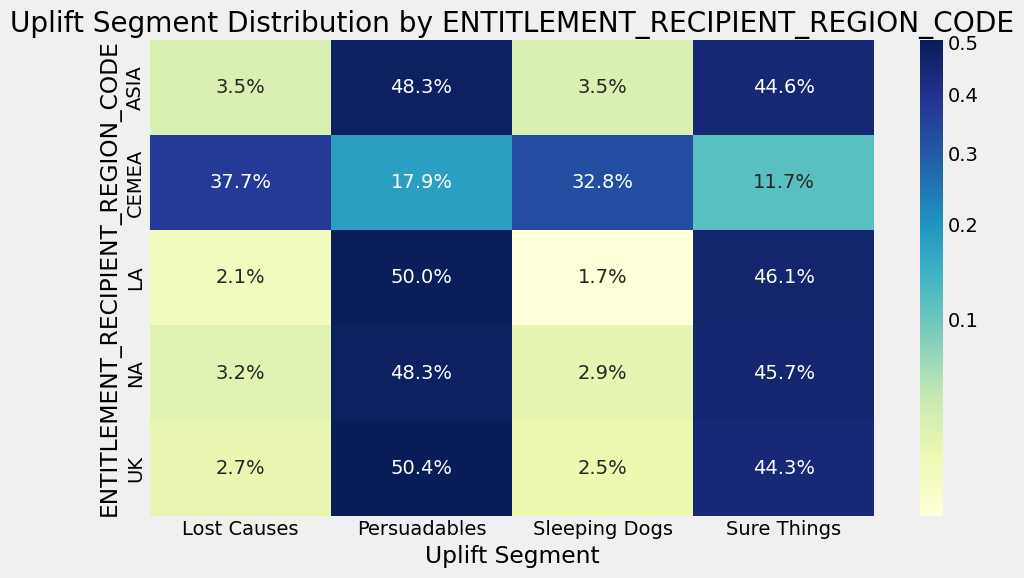

/tmp/ipykernel_7554/215940363.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_total.groupby([col, 'uplift_segment'])


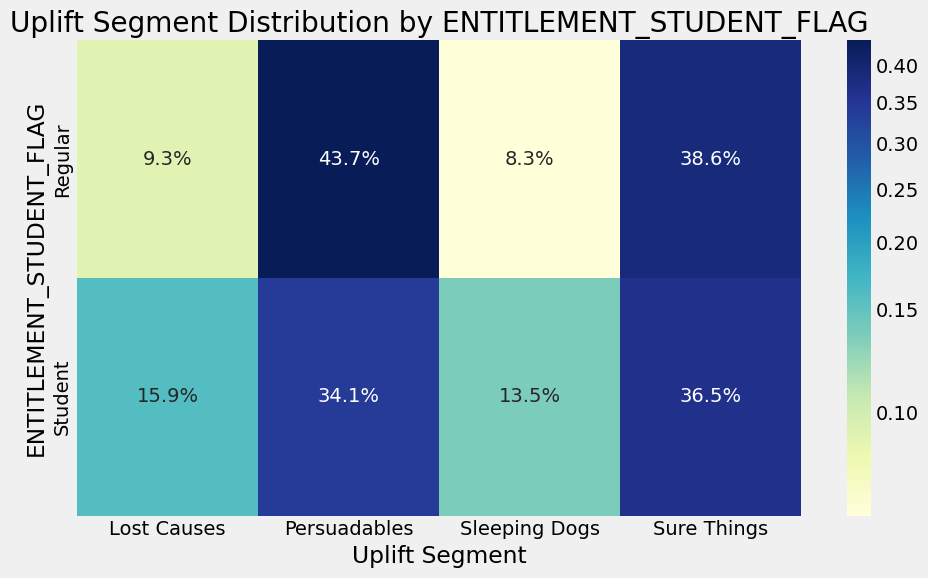

/tmp/ipykernel_7554/215940363.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_total.groupby([col, 'uplift_segment'])


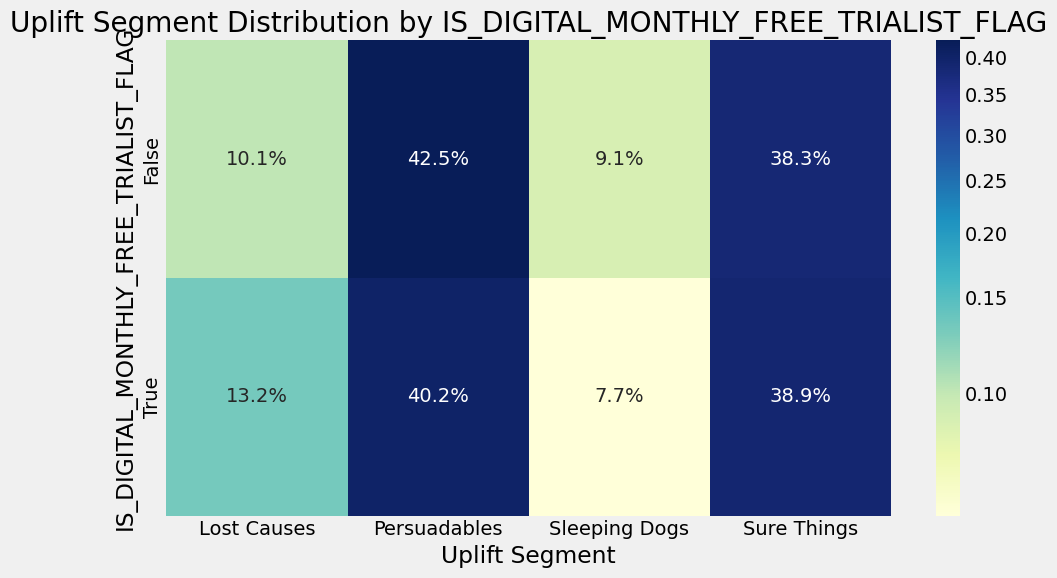

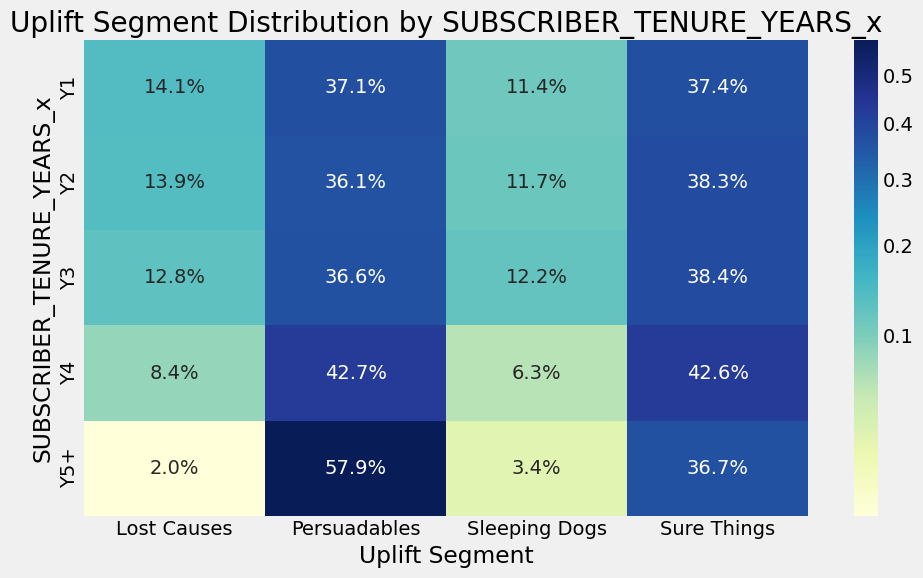

In [39]:
# Ensure output directory exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

columns_to_plot = [
    'ENTITLEMENT_RECIPIENT_REGION_CODE',
    'ENTITLEMENT_STUDENT_FLAG',
    'IS_DIGITAL_MONTHLY_FREE_TRIALIST_FLAG',
    'SUBSCRIBER_TENURE_YEARS_x'
]

for col in columns_to_plot:
    pivot = (
        df_total.groupby([col, 'uplift_segment'])
        .size()
        .unstack(fill_value=0)
    )
    pivot_normalized = pivot.div(pivot.sum(axis=1), axis=0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pivot_normalized,
        annot=True,
        fmt=".1%",
        cmap="YlGnBu",
        cbar=True,
        vmin=0,
        vmax=0.5,
        norm=PowerNorm(gamma=0.5)
    )
    plt.title(f"Uplift Segment Distribution by {col}")
    plt.xlabel("Uplift Segment")
    plt.ylabel(col)
    plt.tight_layout()

    # Save the figure
    filename = f"{output_dir}/uplift_segment_by_{col}.png"
    plt.savefig(filename, dpi=300)
    plt.show()


### Cross Validation

In [40]:
# Ensure index alignment
X_encoded = X_encoded.reset_index(drop=True)
y_bal = y_bal.reset_index(drop=True)
treatment_bal = treatment_bal.reset_index(drop=True)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store fold metrics
fold_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_encoded)):
    print(f"\nFold {fold + 1}")

    # Split data
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y_bal.iloc[train_idx], y_bal.iloc[test_idx]
    treatment_train = treatment_bal.iloc[train_idx]
    treatment_test = treatment_bal.iloc[test_idx]

    # Train uplift model
    uplift_model = UpliftRandomForestClassifier(control_name='0', random_state=42)
    uplift_model.fit(X=X_train.values, treatment=treatment_train.values, y=y_train.values)

    # Predict uplift
    y_pred = uplift_model.predict(X_test.values)

    # Confirm treatment class
    treatment_class = [c for c in uplift_model.classes_ if c != '0'][0]

    # Build uplift dataframe
    uplift_results = pd.DataFrame(y_pred, columns=uplift_model.classes_[1:])
    uplift_results['uplift'] = uplift_results[treatment_class]

    # Build AUUC input
    auuc_metrics = uplift_results[['uplift']].copy()
    auuc_metrics['is_treated'] = (treatment_test.values != '0').astype(int)
    auuc_metrics['conversion'] = y_test.values

    # Compute scores (extract scalar using .item())
    auuc = auuc_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated').item()
    qini = qini_score(auuc_metrics, outcome_col='conversion', treatment_col='is_treated').item()

    # Random AUUC
    auuc_random = auuc_metrics.copy()
    np.random.seed(42)
    auuc_random['uplift'] = np.random.permutation(auuc_random['uplift'].values)
    random_auuc = auuc_score(auuc_random, outcome_col='conversion', treatment_col='is_treated').item()

    # Normalized AUUC
    normalized = (auuc - random_auuc) / abs(random_auuc) if random_auuc != 0 else np.nan

    # Save results
    fold_results.append({
        'Fold': fold + 1,
        'AUUC': auuc,
        'Qini': qini,
        'Random_AUUC': random_auuc,
        'Normalized_AUUC': normalized
    })

    # Print fold summary
    print(f"AUUC: {auuc:.4f}")
    print(f"Qini: {qini:.4f}")
    print(f"Random AUUC: {random_auuc:.4f}")
    print(f"Normalized AUUC: {normalized:.4f}")

# Summary table
results_df = pd.DataFrame(fold_results)
print("\n===== Cross-Validation Summary =====")
print(results_df)
print("\nMean Scores:")
print(results_df.mean(numeric_only=True))



Fold 1


AUUC: 1.0081
Qini: 0.5574
Random AUUC: 0.4613
Normalized AUUC: 1.1852

Fold 2
AUUC: 1.1516
Qini: 0.6998
Random AUUC: 0.4907
Normalized AUUC: 1.3467

Fold 3
AUUC: 1.6254
Qini: 1.2319
Random AUUC: 0.8143
Normalized AUUC: 0.9960

Fold 4
AUUC: 0.9616
Qini: 0.4953
Random AUUC: 0.5413
Normalized AUUC: 0.7766

Fold 5
AUUC: 0.9444
Qini: 0.4791
Random AUUC: 0.5070
Normalized AUUC: 0.8628

Fold 6
AUUC: 0.9000
Qini: 0.4303
Random AUUC: 0.5295
Normalized AUUC: 0.6996

Fold 7
AUUC: 1.1532
Qini: 0.6755
Random AUUC: 0.5966
Normalized AUUC: 0.9328

Fold 8
AUUC: 0.8405
Qini: 0.3681
Random AUUC: 0.3496
Normalized AUUC: 1.4044

Fold 9
AUUC: 1.2146
Qini: 0.7803
Random AUUC: 0.5880
Normalized AUUC: 1.0657

Fold 10
AUUC: 0.9520
Qini: 0.4887
Random AUUC: 0.5481
Normalized AUUC: 0.7369

===== Cross-Validation Summary =====
   Fold      AUUC      Qini  Random_AUUC  Normalized_AUUC
0     1  1.008144  0.557450     0.461342         1.185241
1     2  1.151606  0.699792     0.490737         1.346688
2     3  1.6254

### Hyperparameter Tuning

In [41]:
# Use preprocessed and balanced data
X = X_encoded.reset_index(drop=True)
y = y_bal.reset_index(drop=True)
treatment = treatment_bal.reset_index(drop=True)

# --- Simplified param grid ---
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [5, 10, 'sqrt'],
    'evaluationFunction': ['KL', 'ED', 'Chi'],
    'random_state': [42]
}

# Create all combinations
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# Grid search with CV
for i, params in enumerate(param_combinations):
    print(f"\nTesting combination {i+1}/{len(param_combinations)}: {params}")
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        t_train, t_test = treatment.iloc[train_idx], treatment.iloc[test_idx]

        # Train uplift model
        model = UpliftRandomForestClassifier(control_name='0', **params)
        model.fit(X_train.values, treatment=t_train.values, y=y_train.values)

        # Predict uplift
        y_pred = model.predict(X_test.values)
        uplift_scores = pd.DataFrame(y_pred, columns=model.classes_[1:])
        uplift = uplift_scores.max(axis=1)

        # Prepare evaluation metrics
        metrics_df = pd.DataFrame({
            'uplift': uplift,
            'conversion': y_test.values,
            'is_treated': (t_test.values != '0').astype(int)
        })

        # Compute scores and ensure scalar output
        auuc = float(auuc_score(metrics_df, outcome_col='conversion', treatment_col='is_treated'))
        qini = float(qini_score(metrics_df, outcome_col='conversion', treatment_col='is_treated'))

        print(f"Fold {fold + 1} | AUUC: {auuc:.4f} | Qini: {qini:.4f}")

        fold_results.append({
            'params': params,
            'fold': fold + 1,
            'auuc': auuc,
            'qini': qini
        })

# Best fold summary
results_df = pd.DataFrame(fold_results)
best_row = results_df.loc[results_df['auuc'].idxmax()]

print("\nBest Performing Fold:")
print(best_row)



Testing combination 1/27: {'n_estimators': 50, 'max_features': 5, 'evaluationFunction': 'KL', 'random_state': 42}


KeyboardInterrupt: 